In [2]:
import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

original = pd.read_csv("../로그 데이터/NU-MineBench.csv")
original

,gpa
0,105950216192
1,105943924736
2,105946021888
3,105939873792
4,105941845296
...,...
63973,103568084992
63974,103568404480
63975,103563653120
63976,103565225984


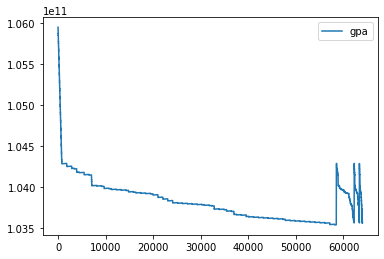

In [4]:
original.plot()

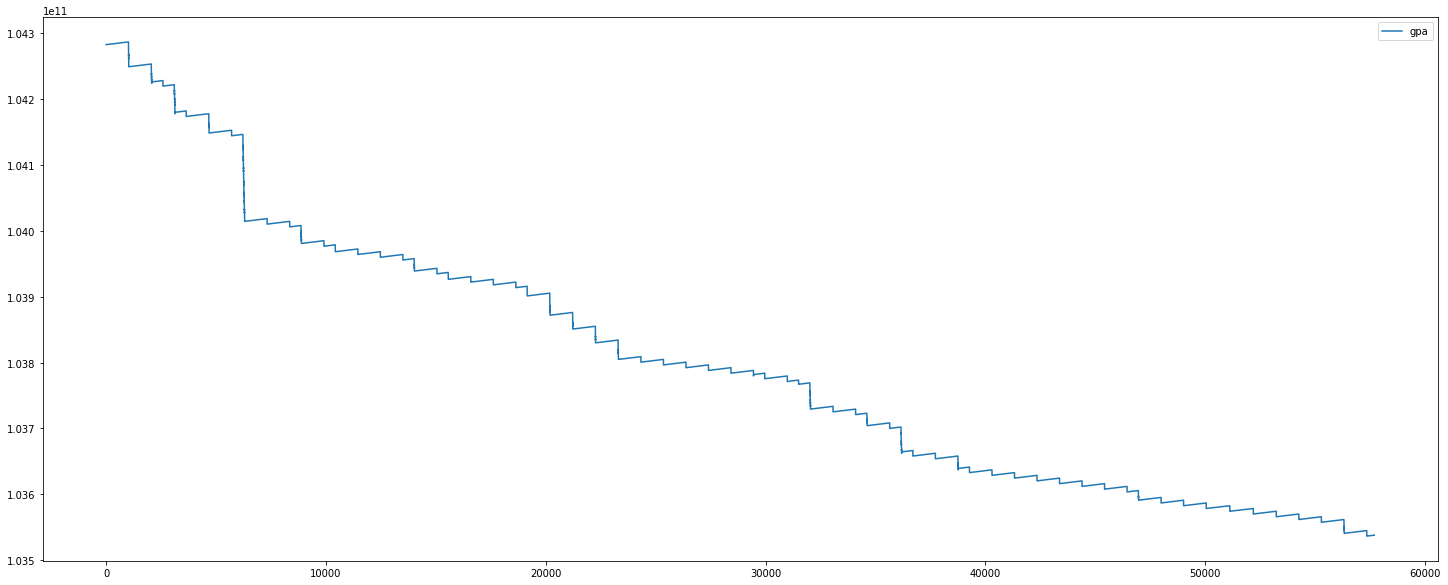

In [5]:
data = original[800:58486].copy().reset_index(drop=True)
data.plot(figsize=(25,10))

In [6]:
len(data)

57686

In [7]:
def delta_slice(data, step, cutoff=None):
    if cutoff:
        data = data[cutoff:].reset_index(drop=True)
    delta = pd.DataFrame(data=[data.loc[i+step] - data.loc[i] for i in range(int(len(data))-step)])
    return delta

In [8]:
pattern_length = 4

delta = delta_slice(data, pattern_length)
delta

,gpa
0,16384
1,16384
2,16384
3,16384
4,16384
...,...
57677,16384
57678,16384
57679,16384
57680,16384


In [9]:
split_index = 50000

train_set = delta[:split_index]
test_set = delta[split_index:].reset_index(drop=True)
train_set, test_set

(         gpa
 0      16384
 1      16384
 2      16384
 3      16384
 4      16384
 ...      ...
 49995  16384
 49996  16384
 49997  16384
 49998  16384
 49999  16384
 
 [50000 rows x 1 columns],
         gpa
 0     16384
 1     16384
 2     16384
 3     16384
 4     12288
 ...     ...
 7677  16384
 7678  16384
 7679  16384
 7680  16384
 7681  16384
 
 [7682 rows x 1 columns])

In [10]:
data_counts = train_set["gpa"].value_counts().to_frame("gpa_counts")
data_counts

,gpa_counts
16384,49383
-4194304,179
-8372224,149
-10485760,48
-2097152,46
12288,39
-8388608,39
-6279168,28
-6283264,22
-4190208,17


In [11]:
threshold_num_of_label = 10
data_counts_threshold = (data_counts >= threshold_num_of_label)["gpa_counts"]
data_counts_threshold.value_counts()

True     12
False    10
Name: gpa_counts, dtype: int64

In [12]:
data_counts_over_threshold = pd.DataFrame(data=data_counts_threshold.index[data_counts_threshold == True], columns=["category"])
data_counts_under_threshold = data_counts_threshold.index[data_counts_threshold == False]

In [13]:
data_counts_over_threshold.iloc[(data_counts_over_threshold["category"]-data_counts_under_threshold[0]).abs().argsort()[0]].values[0]

-10485760

In [14]:
for i in range(len(data_counts_under_threshold)):
    index_for_overlap = train_set["gpa"].index[train_set["gpa"] == data_counts_under_threshold[i]]
    train_set.iloc[index_for_overlap] = data_counts_over_threshold.iloc[(data_counts_over_threshold["category"]-data_counts_under_threshold[i]).abs().argsort()[0]].values[0]

train_set["gpa"].value_counts()

 16384       49392
-4194304       180
-8372224       151
-10485760       55
-2097152        46
 12288          44
-8388608        39
-6279168        28
-6283264        22
-4190208        22
-6287360        11
-10481664       10
Name: gpa, dtype: int64

In [30]:
train_set["gpa"].value_counts().loc[16384]/len(train_set["gpa"])

0.98784

In [16]:
train_set["gpa"].index[train_set["gpa"] == -10481664]

Int64Index([1017, 1029, 2055, 6299, 19149, 20179, 21219, 22253, 23287, 32010], dtype='int64')

In [17]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_set_encoded, train_set_categories = train_set["gpa"].factorize()
train_set_1hot = encoder.fit_transform(train_set_encoded.reshape(-1, 1)).toarray()
train_set_1hot[1016]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
def generate_timeseries(dataset, target, start_index, end_index, history_size, target_size, num_categories):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        
        labels.append(target[i:i+target_size].flatten())
    return np.array(data), np.array(labels)

In [19]:
PAST_HISTORY = 16
FUTURE_TARGET = 8
TRAIN_SPLIT = 40000
BATCH_SIZE = 256
BUFFER_SIZE = 200000

In [20]:
x_train, y_train = generate_timeseries(train_set.values, train_set_1hot, 0, TRAIN_SPLIT, PAST_HISTORY, FUTURE_TARGET, train_set_1hot[0].shape[0])
x_val, y_val = generate_timeseries(train_set.values, train_set_1hot, TRAIN_SPLIT, None, PAST_HISTORY, FUTURE_TARGET, train_set_1hot[0].shape[0])

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.cache().batch(BATCH_SIZE).repeat()

In [21]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
def plot_graphs(history, metric, title=None):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    if title:
        plt.savefig("result/{0}-{1}.png".format(metric, title), dpi=300)
    plt.show()

In [23]:
num_neurons_1 = 64
num_neurons_2 = 64
dropout_rate = 0.2

EPOCHS = 100
EVALUATION_INTERVAL = 156
VAL_STEPS = 50
title = '{0}-{1}-{2}_{3}_{4}'.format(EPOCHS, BATCH_SIZE, num_neurons_1, num_neurons_2, dropout_rate)

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(num_neurons_1, return_sequences=True, input_shape=x_train.shape[-2:]))
model.add(tf.keras.layers.LSTM(num_neurons_2))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(y_train.shape[-1]))
model.add(tf.keras.layers.Activation("relu"))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_history = model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data, validation_steps=VAL_STEPS, callbacks=[tensorboard_callback])

Epoch 1/100
156/156 [==============================] - 2s 10ms/step - loss: 20.2782 - accuracy: 0.1886 - val_loss: 17.3348 - val_accuracy: 0.0138
Epoch 2/100
156/156 [==============================] - 1s 6ms/step - loss: 17.7968 - accuracy: 0.1375 - val_loss: 17.3355 - val_accuracy: 0.0109
Epoch 3/100
156/156 [==============================] - 1s 6ms/step - loss: 17.6789 - accuracy: 0.1549 - val_loss: 17.3344 - val_accuracy: 0.0075
Epoch 4/100
156/156 [==============================] - 1s 6ms/step - loss: 17.6208 - accuracy: 0.1596 - val_loss: 17.2971 - val_accuracy: 0.0050
Epoch 5/100
156/156 [==============================] - 1s 7ms/step - loss: 17.8149 - accuracy: 0.1137 - val_loss: 17.2717 - val_accuracy: 0.0000e+00
Epoch 6/100
156/156 [==============================] - 1s 7ms/step - loss: 17.5670 - accuracy: 0.1610 - val_loss: 17.2675 - val_accuracy: 0.0000e+00
Epoch 7/100
  1/156 [..............................] - ETA: 0s - loss: 17.4992 - accuracy: 0.1523

KeyboardInterrupt: 

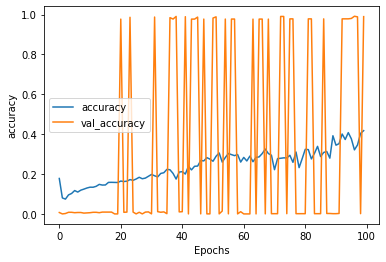

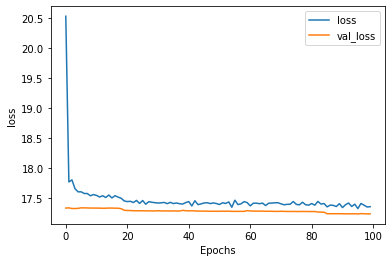

In [189]:
pd.DataFrame.from_dict(model_history.history).to_csv("result/{0}.csv".format(title), index=False)
plot_graphs(model_history, 'accuracy', title)
plot_graphs(model_history, 'loss', title)